# Housekeeping

In [53]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Gathering and Plotting

In [54]:


def get_data():
    WHEAT = yf.download("KE=F", auto_adjust=True, period = 'max')["Close"]
    CORN = yf.download("ZC=F", auto_adjust=True, period = 'max')["Close"]

    df = pd.concat([WHEAT, CORN], axis=1)
    df.columns = ['WHEAT', 'CORN']

    df = df.iloc[-730:-365,:]
    print(df.head())
    return df.dropna()

def plot_price_data(df):
    plt.figure(figsize=(8,5))
    plt.plot(df['WHEAT'], label = 'WHEAT Close')
    plt.plot(df['CORN'], label = 'CORN Close')
    plt.title('WHEAT vs CORN Close prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Calculating Spread and Z-Score

In [55]:
def calculate_spread_zscore(df):
    df['spread'] = df['WHEAT'] - df['CORN']
    df['spread_mean'] = df['spread'].rolling(window=20).mean()
    df['spread_std'] = df['spread'].rolling(window=20).std()
    df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

    
#Plotting Spread
    plt.figure(figsize=(8,5))
    plt.plot(df['spread'], label = 'WHEAT CORN Spread')
    plt.plot(df['spread_mean'], label = 'WHEAT CORN Spread 30 Day Moving Average')
    plt.title('WHEAT CORN Spread and Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


#Plotting zscore
    plt.figure(figsize=(8,5))
    plt.plot(df['zscore'], label = 'Z Score', color='green')
    plt.title('WHEAT CORN ZScore')
    plt.xlabel('Date')
    plt.ylabel('Score')
    plt.axhline(-1, color = 'red', linestyle='-')
    plt.axhline(1, color = 'red', linestyle='-')
    plt.legend()
    plt.grid(True)
    plt.show()


    return df
    


# Strategy and Returns Calculation

In [56]:
#Buy and Sell Signals

def define_signals(df):
    df['position'] = 0
    df.loc[df['zscore'] > 1, 'position'] = -1
    df.loc[df['zscore'] < -1, 'position'] = 1
    df.loc[(df['zscore'] > -0.5) & (df['zscore'] < 0.5), 'position'] = 0
    return df

def explicit_positions(df):
    df['WHEAT_position'] = 0
    df['CORN_position'] = 0
    df.loc[df['position'] == 1, ['WHEAT_position', 'CORN_position']] = [1, -1]
    df.loc[df['position'] == -1, ['WHEAT_position', 'CORN_position']] = [-1, 1]
    return df

def calculate_returns(df):
    df['WHEAT_returns'] = df['WHEAT'].pct_change()
    df['CORN_returns'] = df['CORN'].pct_change()

    df['strategy_returns_explicit'] = (
        df['WHEAT_position'].shift(1) * df['WHEAT_returns'] +
        df['CORN_position'].shift(1) * df['CORN_returns']
    )

    df['strategy_cumulative_explicit'] = (1 + df['strategy_returns_explicit'].fillna(0)).cumprod()
    return df

    

# Performance Summary and Running Code

In [57]:
def performance_summary(df, risk_free_rate=0):
    
    WHEAT_Return = (df['WHEAT_returns'].dropna() + 1).prod() - 1
    CORN_Return = (df['CORN_returns'].dropna() + 1).prod() - 1

    pnl_pct = (df['strategy_cumulative_explicit'].iloc[-1] - 1) * 100
    mean_ret = df['strategy_returns_explicit'].mean()
    std_ret = df['strategy_returns_explicit'].std()

    sharpe = (mean_ret - risk_free_rate / 252) / std_ret * np.sqrt(252)

    print(f"WHEAT CORN Arbitrage Strategy P&L: {pnl_pct:.2f}%")
    print(f"WHEAT CORN Arbitrage Strategy Sharpe Ratio: {sharpe:.2f}")
    print(f"WHEAT Price Change: {WHEAT_Return * 100:.2f}%")
    print(f"CORN Price Change: {CORN_Return * 100:.2f}%")


def main():
    df = get_data()
    plot_price_data(df)
    calculate_spread_zscore(df)
    define_signals(df)
    explicit_positions(df)
    df = calculate_returns(df)
    performance_summary(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

             WHEAT    CORN
Date                      
2022-08-08  847.75  608.50
2022-08-09  851.75  615.50
2022-08-10  872.75  621.25
2022-08-11  889.25  629.25
2022-08-12  889.25  639.75


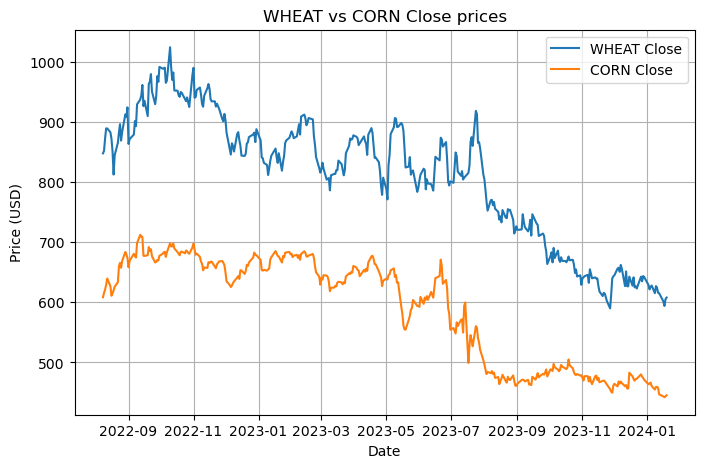

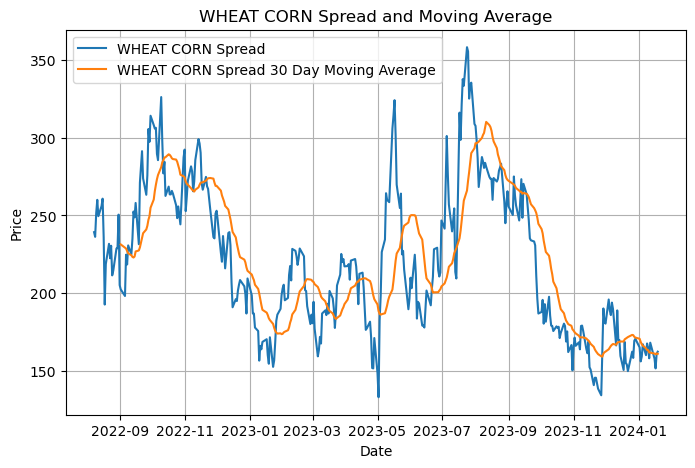

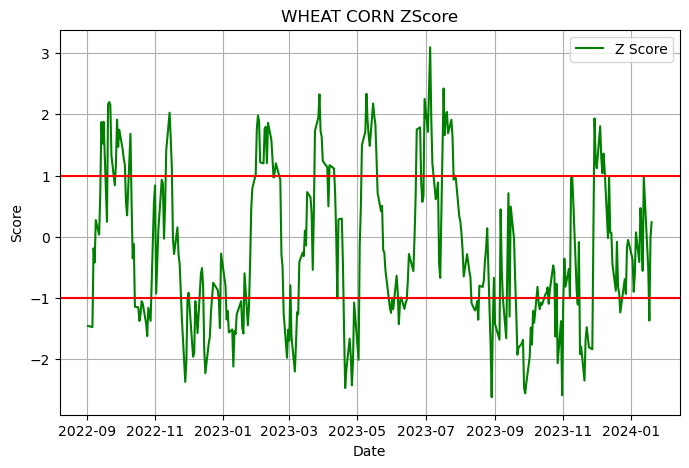

WHEAT CORN Arbitrage Strategy P&L: 25.60%
WHEAT CORN Arbitrage Strategy Sharpe Ratio: 0.86
WHEAT Price Change: -28.28%
CORN Price Change: -26.79%


In [58]:
main()